<a href="https://colab.research.google.com/github/BhargavKondepudi26/pt1/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

If you're already familiar with Colab, check out this video to learn about interactive tables, the executed code history view, and the command palette.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  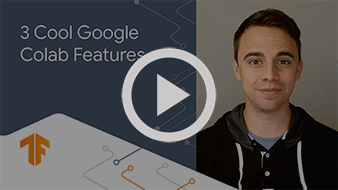
  </a>
</center>

<div class="markdown-google-sans">
  <h1>What is Colab?</h1>
</div>

Colab, or "Colaboratory", allows you to write and execute Python in your browser, with 
- Zero configuration required
- Access to GPUs free of charge
- Easy sharing

Whether you're a **student**, a **data scientist** or an **AI researcher**, Colab can make your work easier. Watch [Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) to learn more, or just get started below!

<div class="markdown-google-sans">

## **Getting started**
</div>

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab notebooks allow you to combine **executable code** and **rich text** in a single document, along with **images**, **HTML**, **LaTeX** and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To learn more, see [Overview of Colab](/notebooks/basic_features_overview.ipynb). To create a new Colab notebook you can use the File menu above, or use the following link: [create a new Colab notebook](http://colab.research.google.com#create=true).

Colab notebooks are Jupyter notebooks that are hosted by Colab. To learn more about the Jupyter project, see [jupyter.org](https://www.jupyter.org).

<div class="markdown-google-sans">

## Data science
</div>

With Colab you can harness the full power of popular Python libraries to analyze and visualize data. The code cell below uses **numpy** to generate some random data, and uses **matplotlib** to visualize it. To edit the code, just click the cell and start editing.

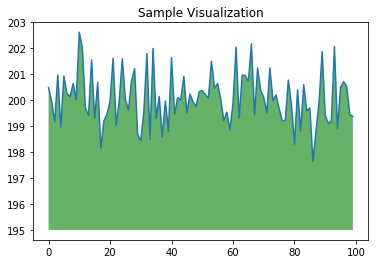

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Sample Visualization")
plt.show()

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from Github and many other sources. To learn more about importing data, and how Colab can be used for data science, see the links below under [Working with Data](#working-with-data).

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb). Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including [GPUs and TPUs](#using-accelerated-hardware), regardless of the power of your machine. All you need is a browser.

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the [machine learning examples](#machine-learning-examples) below.

<div class="markdown-google-sans">

## More Resources

### Working with Notebooks in Colab

</div>

- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)
- <img src="/img/new.png" height="20px" align="left" hspace="4px" alt="New"></img>

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with Data
</div>

- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb) 
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning Crash Course

<div>

These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
</div>

- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- [NeMo Voice Swap](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb): Use Nvidia's NeMo conversational AI Toolkit to swap a voice in an audio fragment with a computer generated one.

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [38]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 15
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from matplotlib import pyplot
import datetime
import quandl

In [41]:
mydata = quandl.get("FRED/DCOILWTICO", trim_start="2012-11-20", trim_end="2022-11-19",  authtoken="JvvFdXyoMVKhCixW4_WA")
mydata.to_csv("crudeprice.csv")

In [42]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('crudeprice.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse, infer_datetime_format=True)
ts = data['Value']
print (data.head())

            Value
Date             
2012-11-20  86.46
2012-11-21  87.08
2012-11-23  87.01
2012-11-26  87.28
2012-11-27  86.81


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [43]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [44]:
test_stationarity(ts)

AttributeError: ignored

In [45]:
ts_log = np.log(ts)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [46]:
ts_log_diff = ts_log - ts_log.shift()

In [47]:
ts_log_diff.dropna(inplace=True)

In [60]:
test_stationarity(ts_log_diff)

AttributeError: ignored

In [49]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


Text(0.5, 1.0, 'Autocorrelation Function')

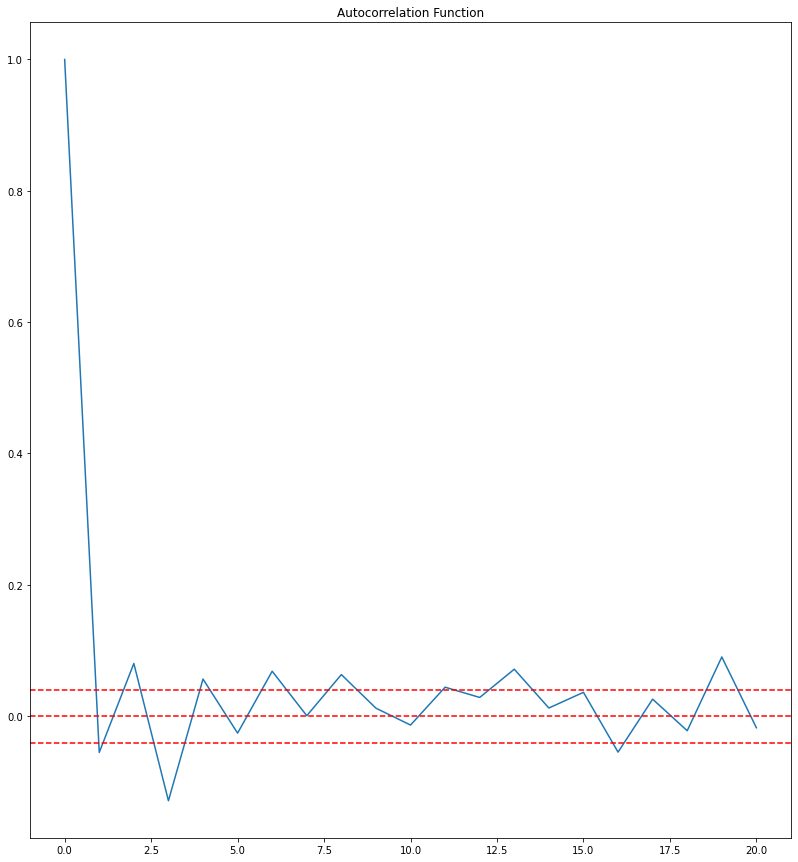

In [61]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='red')
plt.title('Autocorrelation Function')

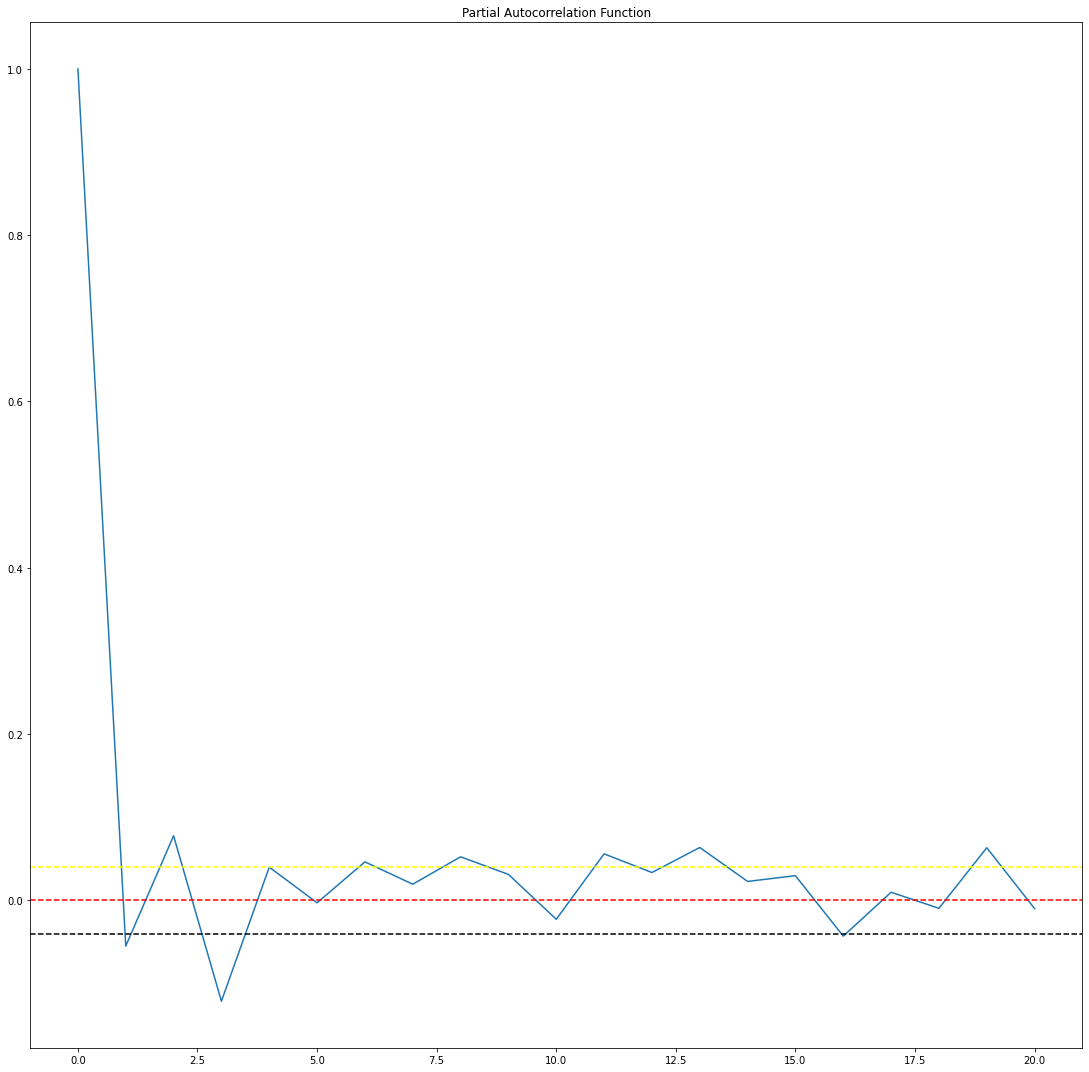

In [52]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='yellow')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [56]:
X = ts.values
size = len(X) - 1
train, test = X[0:size], X[size:]
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast()
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Confidence Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Expected: 110.320
Forecast: 112.362
Standard Error: 2.017
95% Confidence Interval: 108.408 to 116.315


In [57]:
X = ts.values
size = len(X) - 1
train, test = X[0:size], X[size:]
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(disp=False)
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
	forecast, stderr, conf = model_fit.forecast(alpha=a)
	print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))

80.0% Confidence Interval: 112.362 between 109.777 and 114.947
90.0% Confidence Interval: 112.362 between 109.044 and 115.680
95.0% Confidence Interval: 112.362 between 108.408 and 116.315
99.0% Confidence Interval: 112.362 between 107.166 and 117.558


In [58]:
X = ts.values
last_date = data.index[-1] + datetime.timedelta(days=1)
window = 5
model = ARIMA(X, order=(2,1,2))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast(alpha=0.01)
X = np.append(X, forecast)
predictions = {}
print('Expected: %.3f' % X[-1])
print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))
predictions[str(last_date.date())] = (conf[0][0], conf[0][1], forecast[0])

for t in range(window):
    last_date = last_date + datetime.timedelta(days=1)
    model = ARIMA(X, order=(2,1,2))
    model_fit = model.fit(disp=False)
    forecast, stderr, conf = model_fit.forecast(alpha=0.01)
    X = np.append(X, forecast)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))
    predictions[str(last_date.date())] = (conf[0][0], conf[0][1], forecast[0])
    

Expected: 110.831
99.0% Confidence Interval: 110.831 between 105.635 and 116.027
99.0% Confidence Interval: 110.867 between 105.672 and 116.061
99.0% Confidence Interval: 110.939 between 105.745 and 116.133
99.0% Confidence Interval: 110.904 between 105.711 and 116.097
99.0% Confidence Interval: 110.960 between 105.768 and 116.152
99.0% Confidence Interval: 110.927 between 105.736 and 116.117


In [59]:
predictions

{'2022-05-24': (105.63457449335647, 116.02652277996083, 110.83054863665865),
 '2022-05-25': (105.6717158701199, 116.06148623550408, 110.86660105281199),
 '2022-05-26': (105.74505594429742, 116.13264975786107, 110.93885285107925),
 '2022-05-27': (105.71146809651368, 116.0968867255463, 110.90417741102999),
 '2022-05-28': (105.76844938188204, 116.15169419091681, 110.96007178639942),
 '2022-05-29': (105.73613202317688, 116.11720437867629, 110.92666820092658)}

In [55]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)